# Fourier transform

In this part, we look at the effect of filtering in Fourier space.

This gives us a different way of looking at images and yields deeper insights to what is going on when we apply a filter or downsample an image.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
from scipy import ndimage
import cv2

## Some convenience functions

In [17]:
def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1, mode='wrap')
    image = ndimage.convolve(image, kernel2, mode='wrap')
    return image

def fourier_spectrum(im):
    normalized_im = im / np.sum(im)
    f = np.fft.fft2(normalized_im)
    return np.fft.fftshift(f)

def log_magnitude_spectrum(im):
    return np.log(np.abs(fourier_spectrum(im))+1e-8)

def plot_with_spectra(images, titles):
    """Plots a list of images in the first column and the logarithm of their
    magnitude spectrum in the second column."""
    
    assert len(images) == len(titles)
    n_cols = 2
    n_rows = len(images)
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False)

    spectra = [log_magnitude_spectrum(im) for im in images]

    lower = min(np.percentile(s, 0.1) for s in spectra)
    upper = min(np.percentile(s, 99.999) for s in spectra)
    normalizer = mpl.colors.Normalize(vmin=lower, vmax=upper)
    
    for ax, image, spectrum, title in zip(axes, images, spectra, titles):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(title)
        ax[0].set_axis_off()
        c = ax[1].imshow(spectrum, norm=normalizer, cmap='viridis')
        ax[1].set_title('Log magnitude spectrum')
        ax[1].set_axis_off()
        
    fig.tight_layout()
    
def generate_pattern():
    x = np.linspace(0, 1, 256, endpoint=False)
    y = np.sin(x**2 * 16 * np.pi)
    return np.outer(y,y)/2+0.5

im_grass = imread_gray('grass.jpg')
im_zebras = imread_gray('zebras.jpg')
im_pattern = generate_pattern()

## Plotting demo
This is how you can load example images and plot the logarithm of its magnitude spectrum.

Low frequencies appear near the center and higher frequencies towards the outside.

Greener (lighter) colors mean higher values. The color scale is consistent within the subplots of a single plot, but may differ in different plots.

<IPython.core.display.Javascript object>


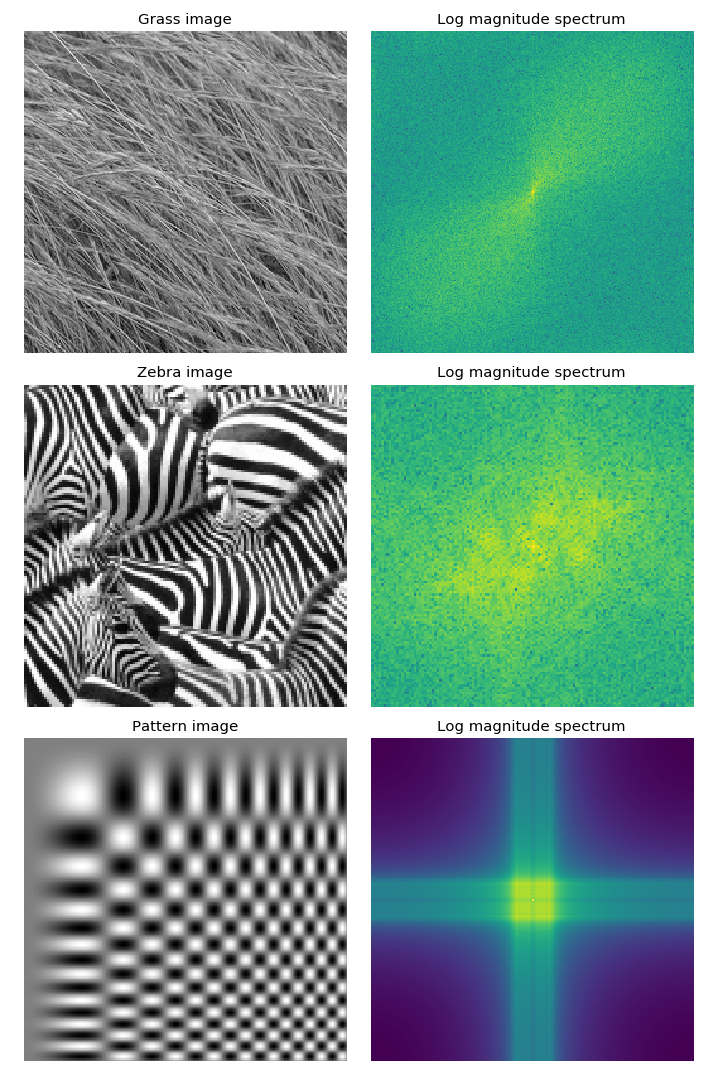

In [18]:
plot_with_spectra([im_grass, im_zebras, im_pattern], ['Grass image', 'Zebra image', 'Pattern image'])

## (a) Blurring

Consider one of the images (`im_grass` is a good choice).

### i)
Implement `filter_box(image, size)` that outputs the box-filtered version of `image`, using `convolve_with_two` (since the box filter is separable). The parameter `size` refers to the side length of the box filter.

### ii) 
Implement `filter_gauss(image, kernel_factor, sigma)` using `convolve_with_two`. The parameter `kernel_factor` defines the half size of the kernel relative to sigma (our rule of thumb from the lecture was to set this as 3).

Plot the image and its blurred versions (with the box and the Gauss filter) along with their spectra using `plot_with_spectra()`.

Vary the size of the box filter. What do you observe? For the Gaussian, change sigma.  What happens if you increase or decrease the `kernel_factor` compared to our rule-of-thumb value 3?

<IPython.core.display.Javascript object>


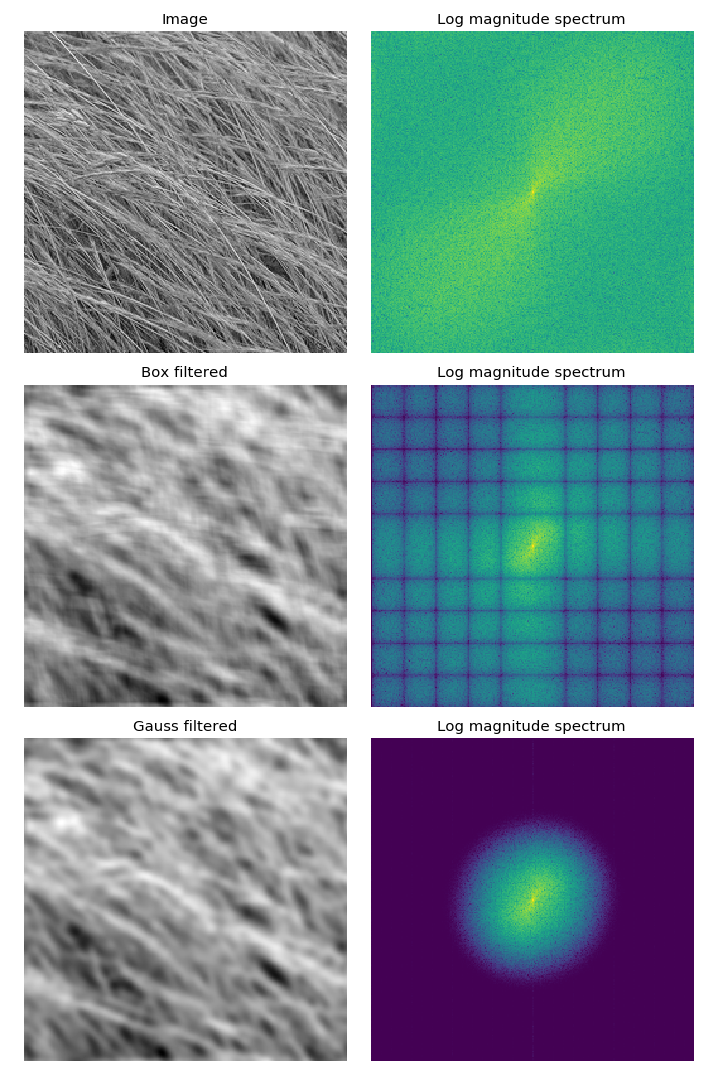

In [39]:
def gauss(x, sigma):
    ### BEGIN SOLUTION
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- x**2 / 2 / sigma**2)
    ### END SOLUTION

def filter_gauss(image, kernel_factor, sigma):
    ### BEGIN SOLUTION
    kernel_halfwidth = int(kernel_factor * sigma)
    x = np.arange(-kernel_halfwidth, kernel_halfwidth + 1)[np.newaxis]
    G = gauss(x, sigma)
    return convolve_with_two(image, G, G.T)
    ### END SOLUTION

def filter_box(image, sigma):
    ### BEGIN SOLUTION
    side = int(round(sigma * 12**0.5))
    B = np.full([1, side], 1/side)
    return convolve_with_two(image, B, B.T)
    ### END SOLUTION
    
import scipy.signal
def filter_box(image, sigma):
    side = int(round(sigma * 12**0.5))
    B = np.full([1, side], 1/side)
    B_2d = scipy.signal.convolve2d(B, B.T, mode='full')
    return scipy.signal.convolve2d(image, B_2d, mode='same', boundary='wrap')

sigma = 3
im = im_grass
gauss_filtered = filter_gauss(im, kernel_factor=6, sigma=sigma)
box_filtered = filter_box(im, sigma=sigma)
plot_with_spectra(
    [im, box_filtered, gauss_filtered], 
    ['Image', 'Box filtered', 'Gauss filtered'])

## (b) Sampling and aliasing

### i)

Implement a function `sample_with_gaps(image, period)`, where `period` is an integer and defines the distance between two sampled points in pixels. The output should have the same size as `image` but have zeros everywhere except at the sampled points, where it should be equal to `image`. For example if `period=2` then every second row and every second column of the image should be zero in the output.

Using `sample_with_gaps`, sample the `im_zebras` image with a period of 2 pixels and plot the original and sampled images along with their spectra.

### iii)
Implement `sample_without_gaps(image, period)`, which is like `sample_with_gaps` but the output does not contain gaps (rows and columns of zeros) and therefore the output size is smaller. What effect do you see in the resulting magnitude spectrum, compared to `sample_with_gaps`?

<IPython.core.display.Javascript object>


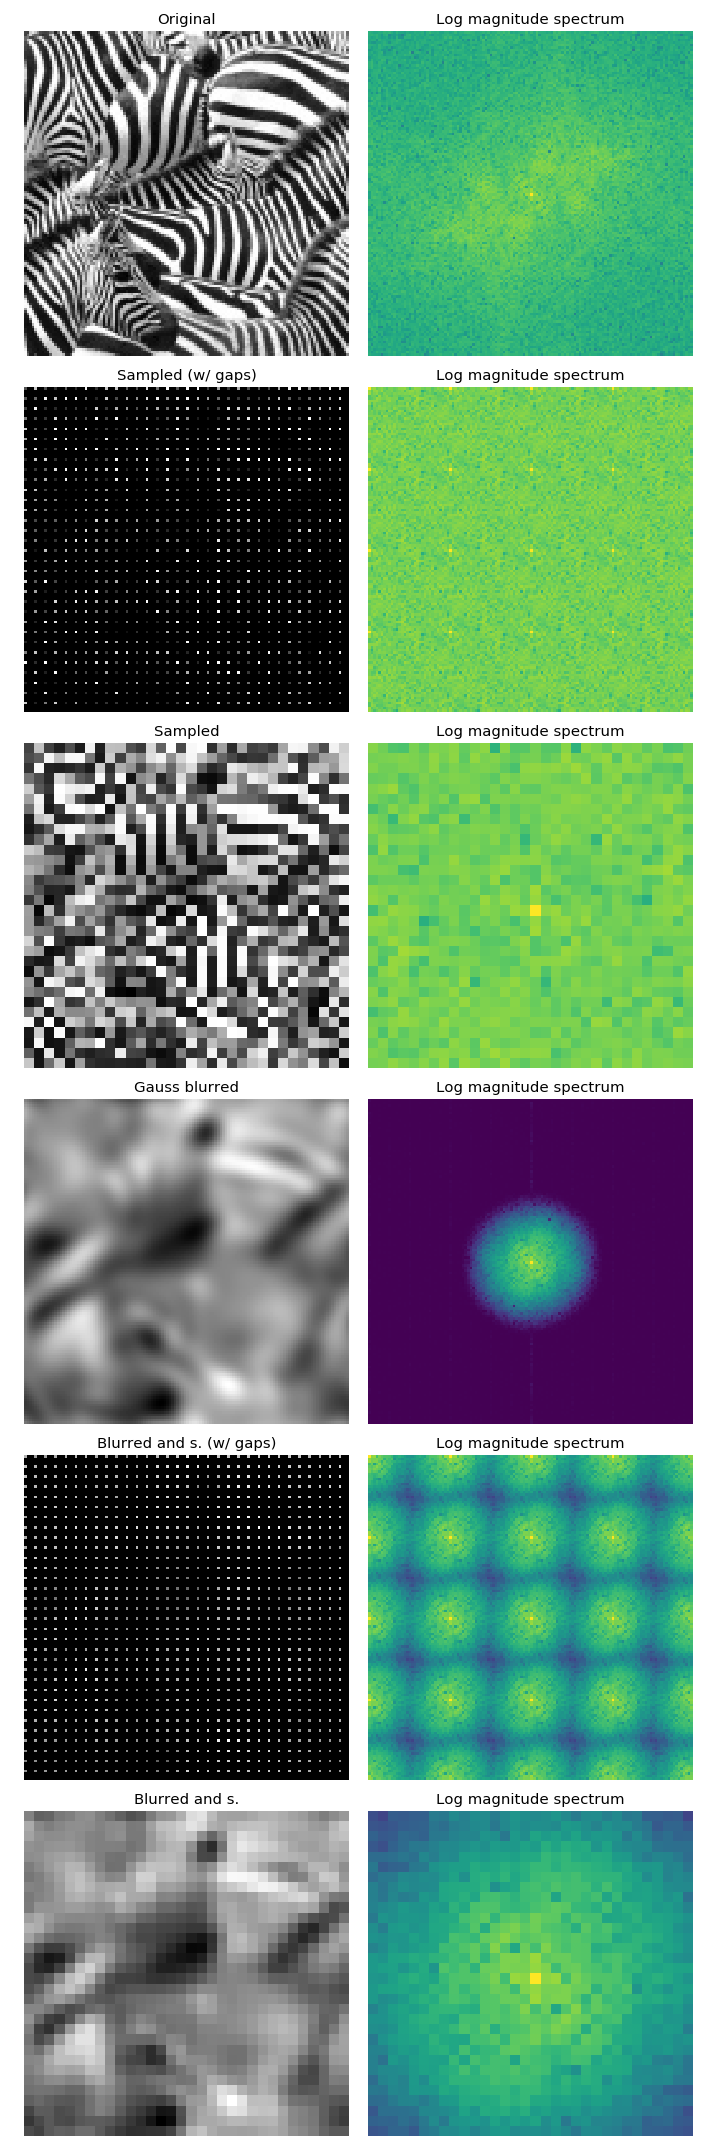

In [16]:
N=4
def sample_with_gaps(im, period):
    ### BEGIN SOLUTION
    out = np.zeros_like(im)
    out[::period, ::period] = im[::period, ::period]
    return out
    ### END SOLUTION

def sample_without_gaps(im, period):
    ### BEGIN SOLUTION
    return im[::period, ::period]
    ### END SOLUTION

im = im_zebras
sampled_gaps = sample_with_gaps(im, N)
sampled = sample_without_gaps(im, N)

blurred = filter_gauss(im, kernel_factor=6, sigma=4)
blurred_and_sampled_gaps = sample_with_gaps(blurred, N)
blurred_and_sampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im, sampled_gaps, sampled, blurred, blurred_and_sampled_gaps, blurred_and_sampled], 
    ['Original', 'Sampled (w/ gaps)', 'Sampled', 'Gauss blurred', 'Blurred and s. (w/ gaps)', 'Blurred and s.'])

### ii)
Consider the image `im_pattern` and sample it with a period of 4, 8 and 16 and plot the resulting spectra. What happens as you increase the sampling period?
Now look at what happens when **Gaussian blurring** is applied before sampling, with different sigma values. Approximately what sigma do you need for avoiding artifacts when `period=16`?

<IPython.core.display.Javascript object>


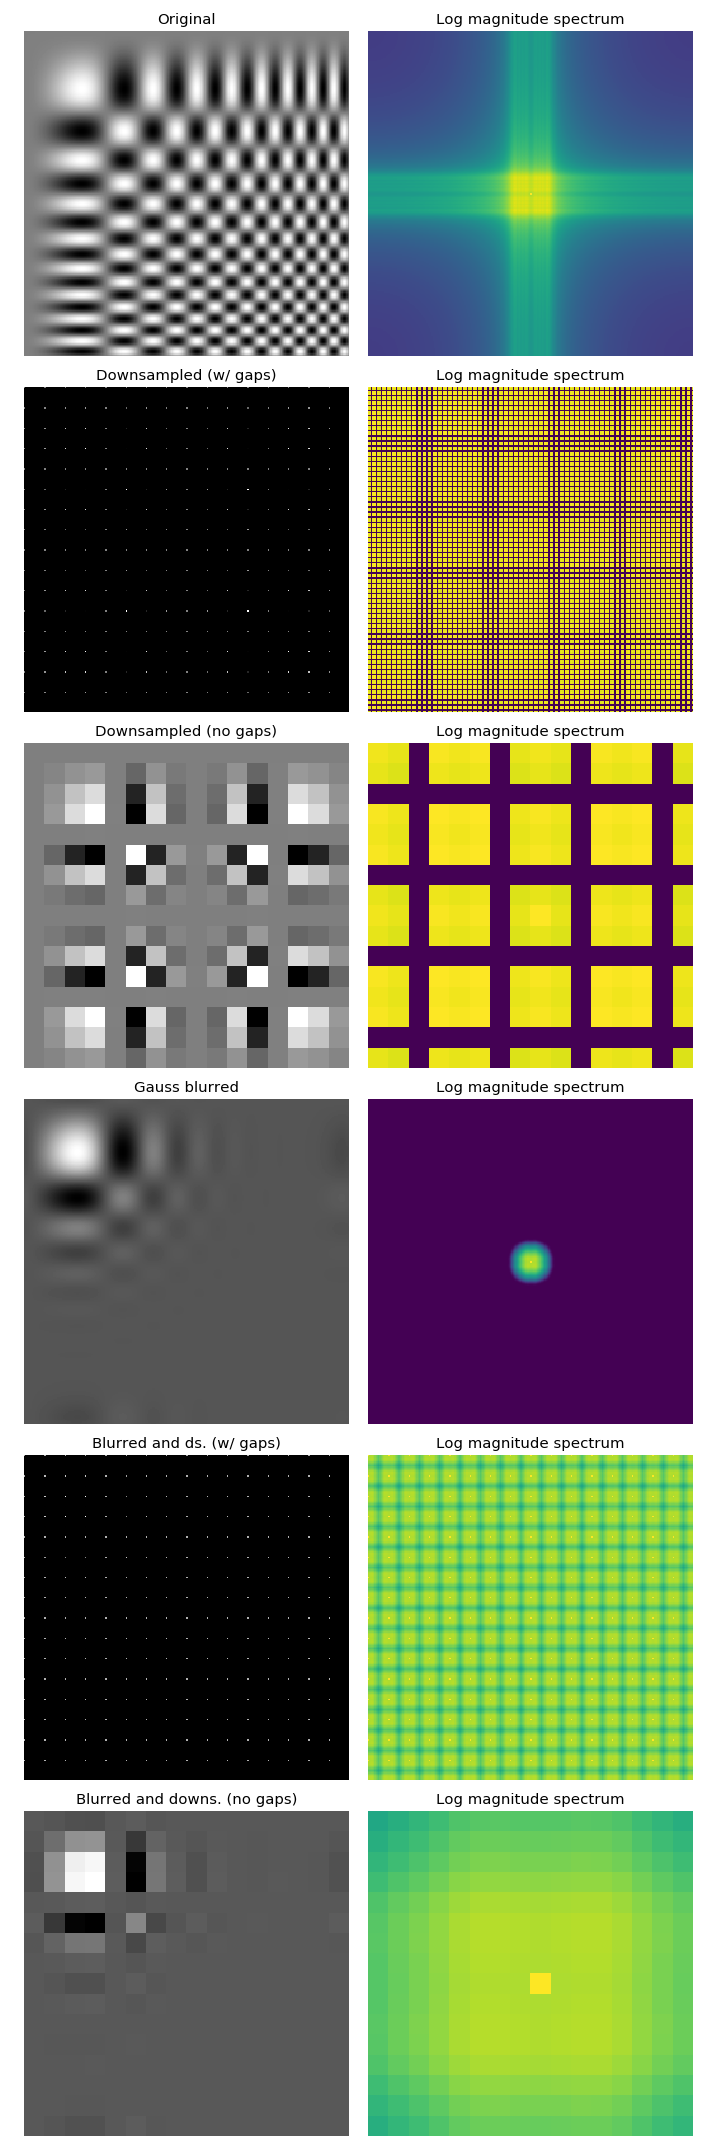

In [14]:
N=16
image = im_pattern
downsampled_gaps = sample_with_gaps(im_pattern, N)
downsampled = sample_without_gaps(im_pattern, N)

blurred = filter_gauss(image, kernel_factor=6, sigma=12)
blurred_and_downsampled_gaps = sample_with_gaps(blurred, N)
blurred_and_downsampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im_pattern, downsampled_gaps, downsampled, blurred, blurred_and_downsampled_gaps, blurred_and_downsampled], 
    ['Original', 'Downsampled (w/ gaps)', 'Downsampled (no gaps)', 'Gauss blurred', 'Blurred and ds. (w/ gaps)', 'Blurred and downs. (no gaps)'])